# Зачем нужны тензоры?

Тензор — это обобщение скаляра, вектора и матрицы на любое количество измерений. Проще говоря, скаляр — это тензор нулевого порядка (одно число), вектор — тензор первого порядка (одномерный массив), матрица — тензор второго порядка (двумерный массив), а тензоры более высокого порядка позволяют хранить данные в нескольких измерениях одновременно.

В основе любой нейросети лежат именно тензоры. Все данные, которые проходят через слои сети, представлены в виде тензоров, как и параметры модели — веса и смещения. Без них было бы невозможно хранение данных, выполнение вычислений и обучение модели.

Главная «фишка» тензоров в машинном обучении — способность не только хранить данные, но и отслеживать вычисления, которые над ними выполнялись. Каждый тензор в моей реализации знает, какие операции его создали и какие другие тензоры участвовали в этих операциях. В итоге формируется граф вычислений (DAG — Directed Acyclic Graph), где вершины — это тензоры, а рёбра — операции между ними.

Благодаря этому графу можно автоматически получать градиенты — частные производные функции потерь по каждому параметру. Когда вызываешь метод backward() на скалярном тензоре (например, функции потерь), граф обходится в обратном порядке, и каждая операция «распределяет» градиенты своим предкам. В результате каждый тензор, участвовавший в вычислениях, получает свой градиент, который можно использовать для обновления параметров модели методом градиентного спуска.

Хочу подчеркнуть, что здесь я не пытаюсь обучать кого-то — это не учебное пособие, а просто способ зафиксировать и закрепить свои знания, а заодно вывести несколько формул для себя. Показывать всю математику матричного дифференцирования в нескольких ноутбуках было бы слишком громоздко. В этом ноутбуке мне интересен именно математический подход: сначала разберу формулы и операции, а потом посмотрю, как Tensor всё это реализует в коде.

Для тех, кому интересно заглянуть в техническую реализацию, исходник лежит в engine/Tensor.py, а также можно посмотреть [видео Андрея Карпатых](https://www.youtube.com/watch?v=VMj-3S1tku0&t=6816s), где он показывает принцип работы класса Value — хоть там только числа, а не тензоры, идея графа вычислений и обратного распространения такая же.

In [13]:
import sys
sys.path.append('..')

from engine.Tensor import Tensor
from engine.graph import draw_dot

# Как работает граф вычислений

Мы можем смотреть на любое математическое выражение как направленный ациклический граф

$$
C_{3 \times 1} = A_{3 \times 3} B_{3 \times 1}
$$

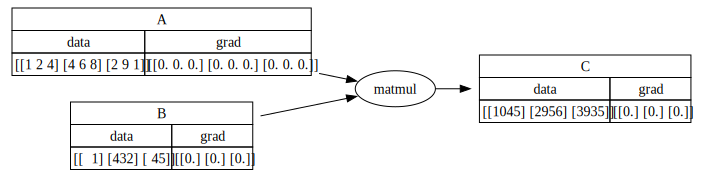

In [14]:
A = Tensor([[1,2,4],[4,6,8],[2,9,1]]); A.label='A'
B = Tensor([[1],[432], [45]]); B.label='B'
C = (A @ B); C.label='C'
draw_dot(C)

Уже сейчас можно заметить, что градиенты у всех тензоров пока что равны нулю

### Попробуем посчитать градиенты для A и B
Как правило, в нейронных сетях градиенты вычисляются для скалярных Loss-функций.
Как мы можем из C получить скалярную функцию? Давайте просто просуммируем все элементы С

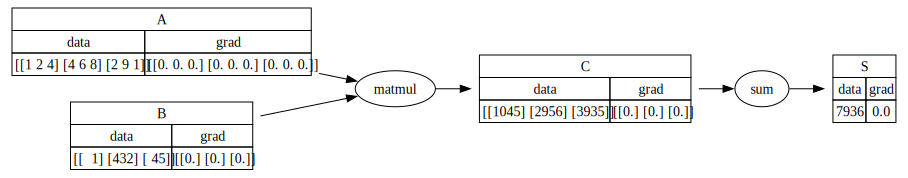

In [15]:
S = C.sum(); S.label='S'
draw_dot(S)

Приступим к вычислению градиентов!

$$S(C)=\sum_{i, j} C_{i j}$$

$$\nabla_{C_{k l}} S=\sum_{i j} 1 \cdot(i \equiv k, j \equiv l)=1$$

Получается, что для каждого элемента C частная производная будет равна 1. Значит, градиентом будет единичный тензор размерности C

$$\nabla_{c_{m \times n}} S=J_{m \times n}$$

Проверим 

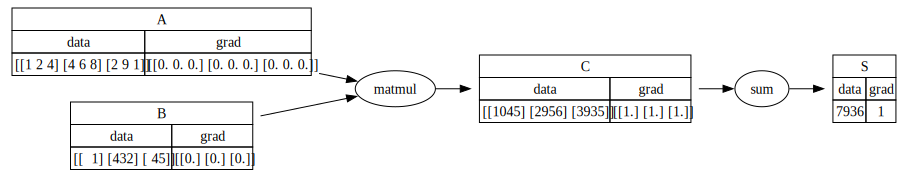

In [16]:
S.grad = 1
S._backward()
draw_dot(S)

А дифференциал dS мы можем записать в виде
$$ d S=\operatorname{tr}\left(\left(\nabla_c S\right)^{\top} d C\right)=\operatorname{tr}\left(J^{\top} d C\right)$$



Эта формула нам еще пригодится. Если мы получим дифференциал dC, то получим градиенты S по A и B.

Сначала распишем дифференциал dC по A




$$\begin{aligned} & C(A)=A B \\ & d C=d A B+A d B=d A B\end{aligned}$$

$$d S=\operatorname{tr}\left(J^{\top} d A B\right)=\operatorname{tr}\left(B J^{\top} d A\right)=\operatorname{tr}\left(\left(J B^{\top}\right)^{\top} d A\right)$$

$$\nabla_A S=J B^T = \nabla_C S B^T $$

Теперь B 

\begin{aligned}
C(B) &= A B \\
dC &= dA \, B + A \, dB = A \, dB \\
dS &= \operatorname{tr}\bigl(J^{\top} A \, dB\bigr)
     = \operatorname{tr}\bigl((A^{\top} J)^{\top} dB\bigr) \\
\nabla_B S &= A^{\top} J = A^{\top} \nabla_C S
\end{aligned}


А теперь давайте посчитаем это все ручками и получим:
$$\nabla_A S=\left(\begin{array}{l}1 \\ 1 \\ 1\end{array}\right)\left(\begin{array}{lll}1 & 432 & 45\end{array}\right)=\left(\begin{array}{lll}1 & 432 & 45 \\ 1 & 432 & 45 \\ 1 & 432 & 45\end{array}\right)$$

$$\nabla_B S=\left(\begin{array}{lll}1 & 4 & 2 \\ 2 & 6 & 9 \\ 4 & 8 & 1\end{array}\right)\left(\begin{array}{l}1 \\ 1 \\ 1\end{array}\right)=\left(\begin{array}{c}7 \\ 17 \\ 13\end{array}\right)$$

Результаты получены, проверим градиенты

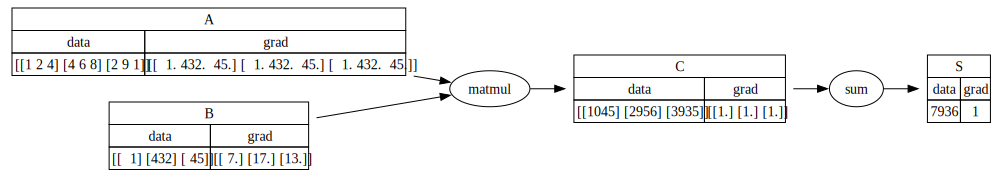

In [17]:
C._backward()
draw_dot(S)

Прекрасно! Всё сходится :)